In [1]:
import os 
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'cnn-time-stack.ipynb',
 'DataCleaning.ipynb',
 'feature select.ipynb',
 'PA_201605-2012001更新R6(20190509).xlsx',
 'README.md',
 'tag盤點表.xlsx',
 'target.jpg',
 'train.csv',
 'train_FeatureSelected.csv',
 'xgboost.ipynb',
 '南亞PA廠資料分析_R6_1219.ipynb']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# load

In [3]:
df = pd.read_csv('train.csv',index_col = 0,parse_dates = True)
print(df.shape)
df.head()

(193825, 93)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD
2016-05-09 00:00:00,400.0,401.957120,400.751866,402.250788,401.148767,401.0,400.050078,403.0,402.0,401.0,...,0.0,1.0,4.051145,4.045683,6.484770,0.0,0.0,-1.000000,1.635186,0.051
2016-05-09 00:10:00,400.0,401.942713,400.949883,402.249145,401.000000,401.0,400.249800,403.0,402.0,401.0,...,0.0,2.0,4.157856,4.152250,6.449888,0.0,0.0,-1.000000,1.625011,0.051
2016-05-09 00:20:00,400.0,401.900145,400.899767,402.101255,401.000000,401.0,400.100155,403.0,402.0,401.0,...,0.0,3.0,4.208122,4.202449,6.440502,0.0,0.0,-0.898558,1.649780,0.051
2016-05-09 00:30:00,400.0,401.949936,400.900210,402.300333,401.000000,401.0,400.144695,403.0,402.0,401.0,...,0.0,4.0,4.152321,4.146723,6.463649,0.0,0.0,-0.509010,1.635187,0.051
2016-05-09 00:40:00,400.0,402.000000,400.850037,402.176070,401.000000,401.0,400.405002,403.0,402.0,401.0,...,0.0,5.0,4.016713,4.011298,6.414799,0.0,0.0,-0.992771,1.654259,0.051


# define target

In [4]:
df['target'] = df['MLPAP_FQ-0619.PV']/df['MLPAP_FQI-0997.PV']
df = df.drop(['MLPAP_FQ-0619.PV','MLPAP_FQI-0997.PV'],axis=1)

count    148472.000
mean            inf
std             NaN
min           0.000
25%           0.899
50%           0.908
75%           0.917
max             inf
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1fd3d224708>,
 'caps': [<matplotlib.lines.Line2D at 0x1fd3d224ec8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fd3d22dac8>],
 'medians': [<matplotlib.lines.Line2D at 0x1fd3d21cfc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fd3d212fc8>],
 'means': []}

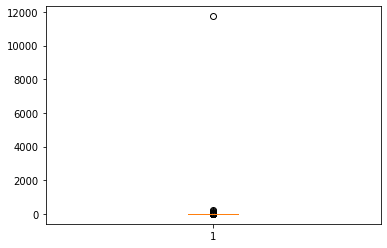

In [5]:
print(df['target'].describe().apply(lambda x:round(x,3)))
plt.boxplot(df['target'].dropna())

In [6]:
# IQR Filter
Q3 = df['target'].quantile(0.75)
Q1 = df['target'].quantile(0.25)
IQR = Q3 - Q1
C = (df['target']<Q1-1.5*IQR)|(df['target']>Q3+1.5*IQR)
out_idx = df.loc[C].index.tolist()
df = df.drop(out_idx)

count    136416.000000
mean          0.907720
std           0.012387
min           0.872412
25%           0.899622
50%           0.907436
75%           0.915682
max           0.943926
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1fd3d3e7fc8>,
 'caps': [<matplotlib.lines.Line2D at 0x1fd3d3e4a88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fd3d3e7608>],
 'medians': [<matplotlib.lines.Line2D at 0x1fd3d3ddf88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fd3d3d78c8>],
 'means': []}

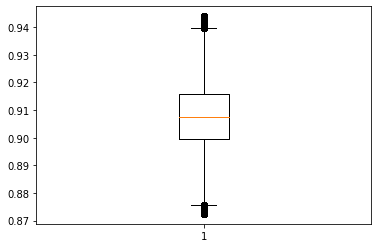

In [7]:
print(df['target'].describe())
plt.boxplot(df['target'].dropna())

In [8]:
# Quantile Filter
ub = df['target'].quantile(0.95)
lb = df['target'].quantile(0.05)
C = (df['target']<lb)|(df['target']>ub)
out_idx = df.loc[C].index.tolist()
df = df.drop(out_idx)

count    122774.000000
mean          0.907689
std           0.009630
min           0.887309
25%           0.900449
50%           0.907436
75%           0.914657
max           0.928837
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1fd3e833f48>,
 'caps': [<matplotlib.lines.Line2D at 0x1fd3e830f08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fd3e8333c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1fd3e828e88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fd3e828f88>],
 'means': []}

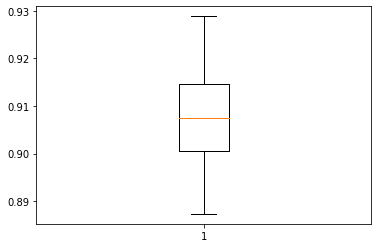

In [9]:
print(df['target'].describe())
plt.boxplot(df['target'].dropna())

In [10]:
# dropna
print(df.shape)
df = df.dropna(subset=['target'])
print(df.shape)

(168127, 92)
(122774, 92)


# scaler features

In [11]:
from sklearn.preprocessing import StandardScaler
import warnings;warnings.simplefilter('ignore')

sc = StandardScaler()
x_col = df.drop('target',axis=1).columns.tolist()
df[x_col] = sc.fit_transform(df[x_col])
df.head()

,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,...,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,7.960528,4.158262,2.292114,1.071367,0.766047,0.231608,-0.680941,-1.063656,-0.881876,-0.223003,...,-1.638534,-2.620349,-2.620349,-7.954421,-0.488124,-0.488124,-4.023225,-1.012546,-0.088237,0.914125
2016-05-10 08:20:00,7.960528,4.164772,2.292114,1.104084,0.766047,0.239674,-0.680941,-1.063656,-0.881876,-0.223003,...,-1.638514,-2.615166,-2.615166,-7.929338,-0.488124,-0.488124,-4.029503,-0.979549,-0.088237,0.919765
2016-05-10 08:30:00,7.960528,4.174848,2.292114,1.086048,0.766047,0.231608,-0.680941,-1.063656,-0.881876,-0.223003,...,-1.638495,-2.617471,-2.617471,-7.933726,-0.488124,-0.488124,-4.017335,-0.973227,-0.088237,0.926346
2016-05-10 23:40:00,7.767594,4.635738,2.689318,1.401524,0.907083,0.392778,-0.900801,-1.741703,-1.506409,-0.859314,...,-1.636723,-2.612923,-2.612923,-6.819627,-0.488124,-0.488124,-2.798058,-0.838001,-0.088237,0.906781
2016-05-10 23:50:00,7.796519,4.666535,2.727902,1.401524,0.907083,0.392778,-0.900801,-1.741703,-1.441295,-0.859314,...,-1.636703,-2.621043,-2.621043,-6.875791,-0.488124,-0.488124,-2.799185,-0.866150,-0.088237,0.926688


# Removing features with low variance

In [12]:
import statistics as stat

v_lst = pd.DataFrame()
for c in tqdm(x_col):
    v_lst.loc[c,'var'] = stat.variance(df[c])

In [13]:
v_lst.sort_values(by='var').head()

,var
MLPAP_TJR-0715B1.PV,1.000008
MLPAP_TI-0706B03,1.000008
MLPAP_TI-0716A09,1.000008
MLPAP_TI-0706B05,1.000008
MLPAP_TI-0716A21,1.000008


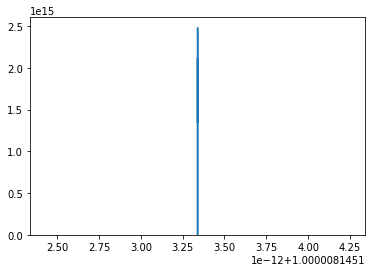

In [14]:
sns.distplot(v_lst)

# corr

In [15]:
df.iloc[:,10:20].corr().style.background_gradient()

,MLPAP_TI-0706B12,MLPAP_TI-0706B13,MLPAP_TI-0706B14,MLPAP_TI-0706B15,MLPAP_TI-0706B16,MLPAP_TI-0706B17,MLPAP_TI-0706B18,MLPAP_TI-0706B19,MLPAP_TI-0706B20,MLPAP_TI-0706B21
MLPAP_TI-0706B12,1,0.952159,0.9593,0.608369,0.933812,0.879983,0.787719,0.7144,0.625702,0.147841
MLPAP_TI-0706B13,0.952159,1,0.996574,0.641647,0.993322,0.978008,0.929391,0.877451,0.808941,0.214268
MLPAP_TI-0706B14,0.9593,0.996574,1,0.664708,0.995243,0.97289,0.915472,0.857848,0.782953,0.213248
MLPAP_TI-0706B15,0.608369,0.641647,0.664708,1,0.67361,0.656649,0.619366,0.603623,0.562007,0.222849
MLPAP_TI-0706B16,0.933812,0.993322,0.995243,0.67361,1,0.988519,0.944327,0.894659,0.826967,0.235467
MLPAP_TI-0706B17,0.879983,0.978008,0.97289,0.656649,0.988519,1,0.982236,0.949279,0.898156,0.258692
MLPAP_TI-0706B18,0.787719,0.929391,0.915472,0.619366,0.944327,0.982236,1,0.988916,0.96075,0.278672
MLPAP_TI-0706B19,0.7144,0.877451,0.857848,0.603623,0.894659,0.949279,0.988916,1,0.989152,0.290433
MLPAP_TI-0706B20,0.625702,0.808941,0.782953,0.562007,0.826967,0.898156,0.96075,0.989152,1,0.293546
MLPAP_TI-0706B21,0.147841,0.214268,0.213248,0.222849,0.235467,0.258692,0.278672,0.290433,0.293546,1


# 處裡共線性

In [16]:
corrs = abs(df.corr())
threshold = 0.8
above_threshold_vars = {}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [17]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  66


In [18]:
# do remove
df = df.drop(cols_to_remove,axis=1)

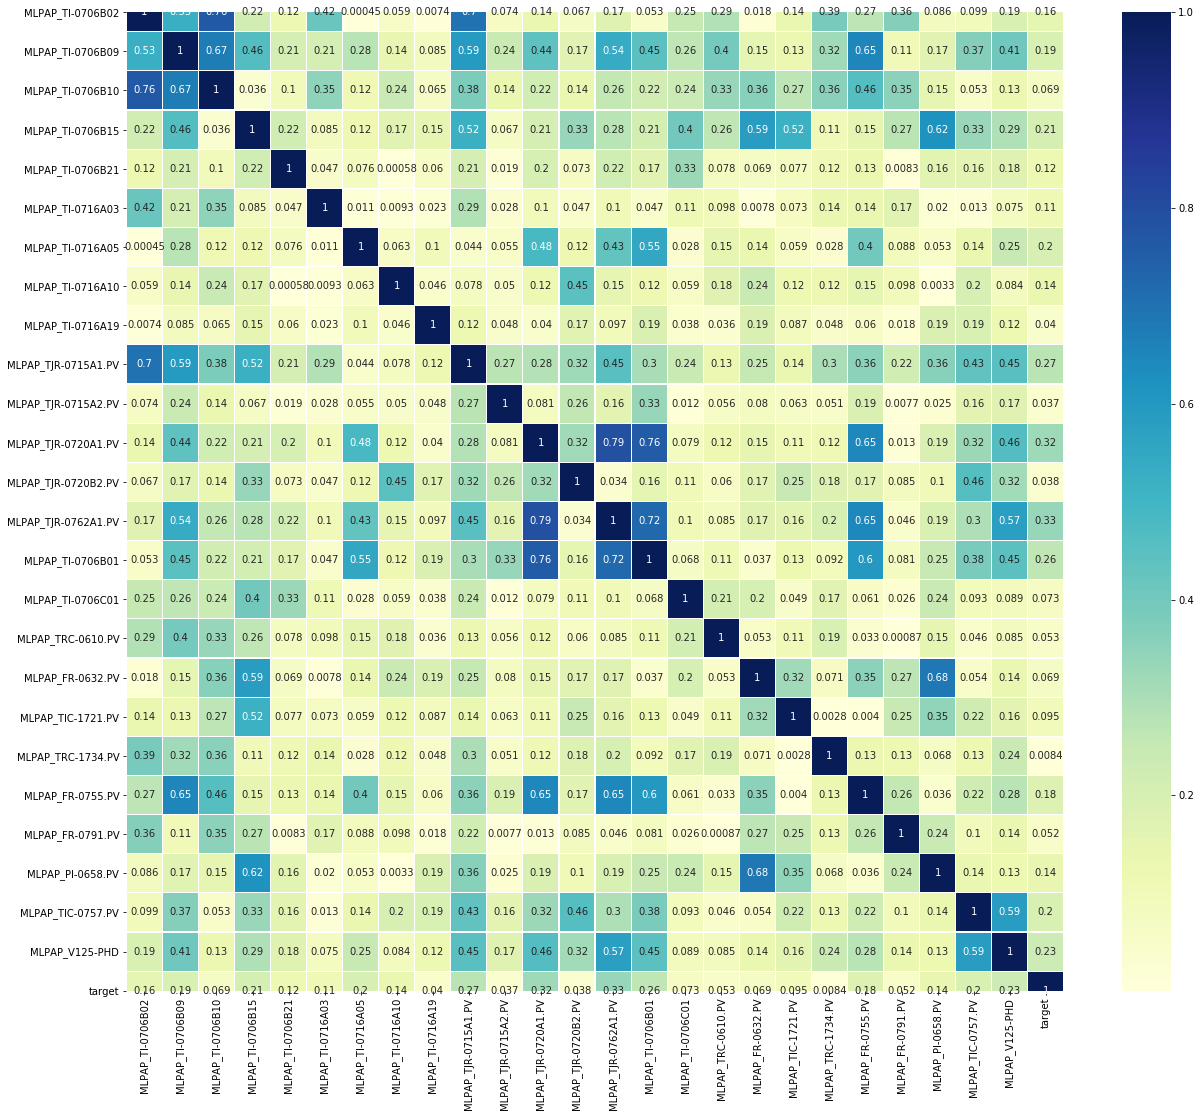

In [19]:
# after remove check corr
fig = plt.figure(figsize=(21,18))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

# Recursive Feature Elimination

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe = RFE(estimator = LinearRegression(),
          n_features_to_select = 16)

X = df
y = df['target']

new_X = rfe.fit_transform(X,y)
new_X = pd.DataFrame(new_X, index = X.index, columns = X.columns[rfe.get_support()])
new_X.head()

,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B15,MLPAP_TI-0716A05,MLPAP_TI-0716A10,MLPAP_TJR-0715A1.PV,MLPAP_TJR-0762A1.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_TIC-1721.PV,MLPAP_FR-0755.PV,MLPAP_FR-0791.PV,MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,-1.063656,-0.881876,0.436522,0.448320,0.250624,10.862927,0.796892,3.036418,-4.444046,3.099350,-2.620349,-7.954421,-4.023225,-1.012546,-0.088237,0.914125
2016-05-10 08:20:00,-1.063656,-0.881876,0.436522,0.448320,0.250624,10.895595,0.797109,2.863638,-4.435347,3.272202,-2.615166,-7.929338,-4.029503,-0.979549,-0.088237,0.919765
2016-05-10 08:30:00,-1.063656,-0.881876,0.436832,0.448320,0.250624,10.915349,0.797007,3.006192,-4.445760,3.596146,-2.617471,-7.933726,-4.017335,-0.973227,-0.088237,0.926346
2016-05-10 23:40:00,-1.741703,-1.506409,0.411823,0.468479,0.225612,9.160618,0.763807,1.710473,-3.055443,3.361722,-2.612923,-6.819627,-2.798058,-0.838001,-0.088237,0.906781
2016-05-10 23:50:00,-1.741703,-1.441295,0.412133,0.468479,0.225612,9.177640,0.764321,1.822236,-3.043572,3.029452,-2.621043,-6.875791,-2.799185,-0.866150,-0.088237,0.926688


In [21]:
df = new_X

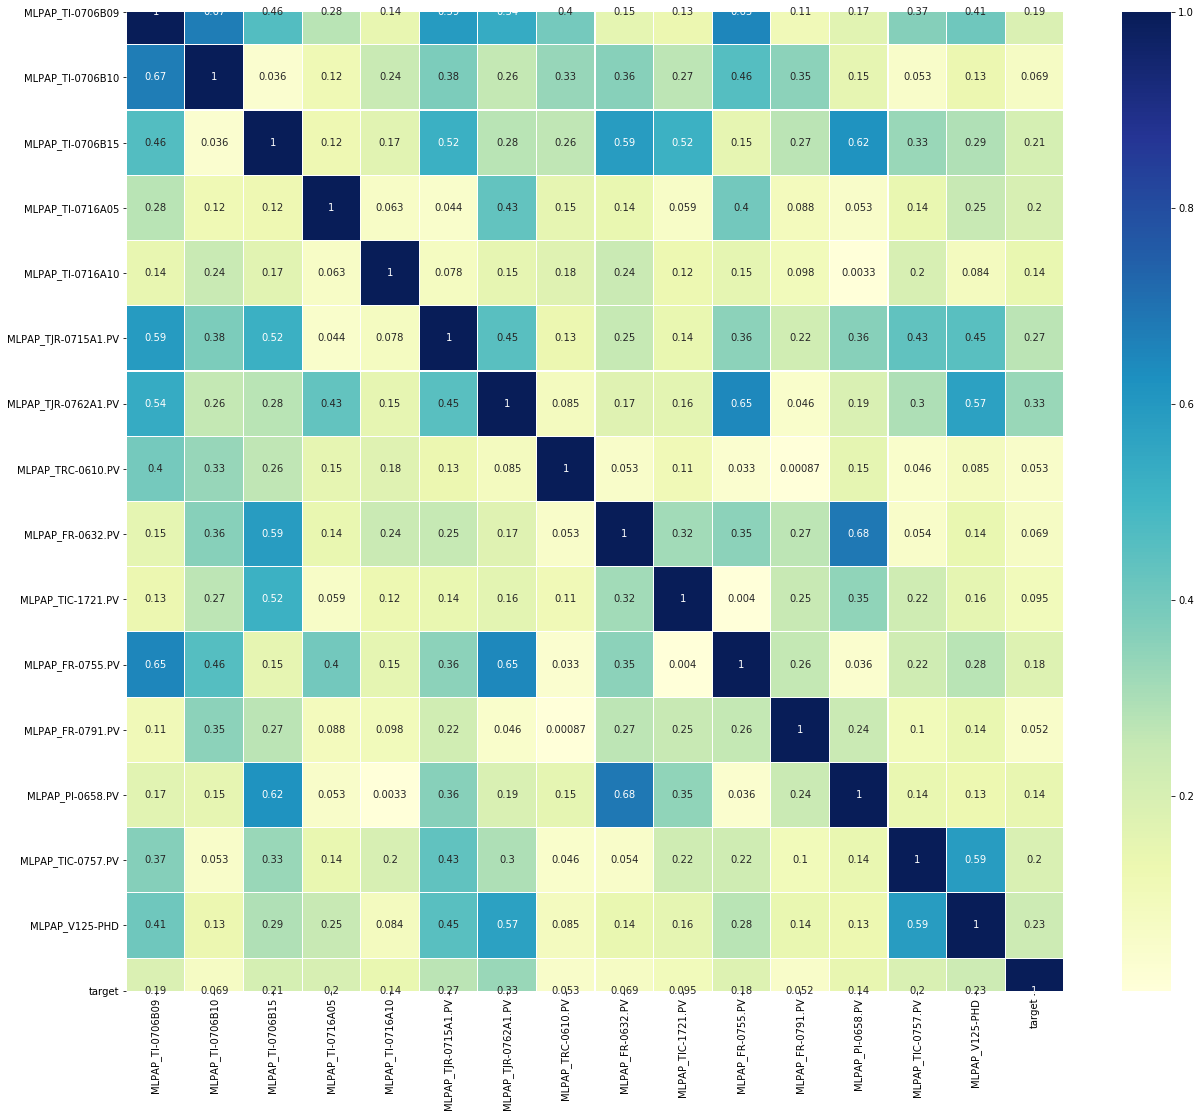

In [22]:
fig = plt.figure(figsize=(21,18))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

In [23]:
print(df.shape)
print(df.isnull().sum().sum())
df.head()

(122774, 16)
0


,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B15,MLPAP_TI-0716A05,MLPAP_TI-0716A10,MLPAP_TJR-0715A1.PV,MLPAP_TJR-0762A1.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_TIC-1721.PV,MLPAP_FR-0755.PV,MLPAP_FR-0791.PV,MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,-1.063656,-0.881876,0.436522,0.448320,0.250624,10.862927,0.796892,3.036418,-4.444046,3.099350,-2.620349,-7.954421,-4.023225,-1.012546,-0.088237,0.914125
2016-05-10 08:20:00,-1.063656,-0.881876,0.436522,0.448320,0.250624,10.895595,0.797109,2.863638,-4.435347,3.272202,-2.615166,-7.929338,-4.029503,-0.979549,-0.088237,0.919765
2016-05-10 08:30:00,-1.063656,-0.881876,0.436832,0.448320,0.250624,10.915349,0.797007,3.006192,-4.445760,3.596146,-2.617471,-7.933726,-4.017335,-0.973227,-0.088237,0.926346
2016-05-10 23:40:00,-1.741703,-1.506409,0.411823,0.468479,0.225612,9.160618,0.763807,1.710473,-3.055443,3.361722,-2.612923,-6.819627,-2.798058,-0.838001,-0.088237,0.906781
2016-05-10 23:50:00,-1.741703,-1.441295,0.412133,0.468479,0.225612,9.177640,0.764321,1.822236,-3.043572,3.029452,-2.621043,-6.875791,-2.799185,-0.866150,-0.088237,0.926688


# save

In [24]:
df.to_csv('./train_FeatureSelected.csv')